<a href="https://colab.research.google.com/github/oliverwsd/Deep-Portfolio/blob/master/deepPortfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers
from keras.constraints import maxnorm
from keras.models import load_model
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

matplotlib.rcParams[ 'figure.figsize' ] = ( 20, 6 )


#packages for modelling
import tensorflow.compat.v1 as tfo
import tensorflow as tf
import random as rd
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal

#packages for plotting
%matplotlib inline
import matplotlib.dates as md
import pydot

#packages for extraction and saving data
import os
import glob as glob
import csv

#packages for date handling
import datetime
from time import time

In [3]:
#Set seed
seed = 1234
rd.seed(seed)
np.random.seed(seed) # set numpy seed
tf.random.set_seed(seed) # set TF seed

### 1. Data

In [4]:
def normalize_data(df):
    '''
    Use the preprocessing object MinMaxScaler from sklearn library to normalize the data.
    The out dataframe has the same index and column
    '''
    x = df.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_n = pd.DataFrame(x_scaled, index=df.index, columns=df.columns)
    return df_n

In [5]:
from io import StringIO
import csv

#index_csv = 'https://raw.githubusercontent.com/oliverwsd/Deep-Portfolio//master/sp500_index.csv'
#stock_csv = 'https://raw.githubusercontent.com/oliverwsd/Deep-Portfolio/master/stock.csv'
stock_pct_csv = 'https://raw.githubusercontent.com/oliverwsd/Deep-Portfolio/master/stock_pct.csv'

stock_csv = 'https://raw.githubusercontent.com/oliverwsd/Deep-Portfolio/master/ibb_stocks.csv'
index_csv = 'https://raw.githubusercontent.com/oliverwsd/Deep-Portfolio/master/IBB_index.csv'


# read csv
stock_last_price = pd.read_csv(stock_csv,index_col=0)
stock_pct = pd.read_csv(stock_pct_csv,index_col=0)

index = pd.read_csv(index_csv,index_col=0)
index_last_price = index['Adj Close']
index_pct = index['Adj Close'].pct_change()

# # stock data
# s_lp_calibrate = stock_last_price.iloc[:780, :]
# s_lp_validate = stock_last_price.iloc[780:, :]

# # s&p 500 data
# i_lp_calibrate = pd.Series(index_last_price)[:780]
# i_lp_validate = pd.Series(index_last_price)[780:]
stock_last_price.index= pd.to_datetime(stock_last_price.index)

In [6]:
list_tickers = stock_last_price.columns # array type
#stock_last_price.index= pd.to_datetime(stock_last_price.index) 
DF_adj_close_n = normalize_data(stock_last_price) # normalized adj close

### 2. Deep AE

In [8]:
# Training Parameters
learning_rate = 0.0004 # learning rate for Adam
num_steps = 500 # number of training steps (epochs)
batch_size = 30 # size of the batches
lambd = 0.12 # lambda for regularization
val_dropout = 0.89 # keep probability for dropout
display_step = 10 # stepsize for printing training epochs

# Network
#traindays = 780 
traindays = 470 
num_input = traindays # dimensions fo input layer
num_encode_1 = 250 # dimensions of hidden layer of encoder
n_code = 5  # dimensions of bottleneck layer (output of encoder and input of decoder)
num_decode_1 = 250 # dimensions of hidden layer of decoder
num_output = num_input # dimensions of last layer of decoder

trainset = DF_adj_close_n.iloc[range(traindays),:].values.T

In [9]:
def plot_commonals(pred_values, real_values, tickers):
    '''
    Create a bar plot of the MSE of the predictions over their real value.
    Warning: the pred_values, real_values and tickers must be sorted the same way!
    
    Modification: description extended
    '''
    # Compute the array of the mean squared errors
    MSE_arr = ((pred_values - real_values)**2).mean(axis=1)
    MSE_df = pd.DataFrame(MSE_arr, index = tickers, columns=['MSE'])
    MSE_df = MSE_df.sort_values('MSE')
    indexes = MSE_df.index
    cutted_indexes = [i for i in indexes]
    for i in range(len(cutted_indexes)):
        if i%5 != 0 and i != 0 and i!= len(cutted_indexes)-1:
            cutted_indexes[i] = ''
    for i in range(2,5):
        cutted_indexes[-i] = ''
    MSE_df = pd.DataFrame(MSE_df.values, index = cutted_indexes, columns=['MSE'])
    MSE_df_test = MSE_df[:]
    MSE_df_test.plot.bar()
    plt.title('Commonals')
    plt.savefig('List of all commonals')
    plt.show()

In [10]:
def return_commonals(pred_values, real_values, tickers, S, N): 
    '''
    Return a Data Frame with the MSE of the N most commonals and the S-N least commonals
    (same dataframe as in the plot_commonals function)
    Warning: the pred_values, real_values and tickers must be sorted the same way!
    
    Modification: description extended
    '''
    MSE_arr = ((pred_values - real_values)**2).mean(axis=1)
    MSE_df = pd.DataFrame(MSE_arr, index = tickers, columns=['MSE'])
    MSE_df = MSE_df.sort_values('MSE')

    # Take 10 with lowest MSE (most commonals)
    most_c_df = MSE_df.sort_values('MSE', ascending=True).iloc[:N,:]

    # Take S-10 with highest MSE (least commonals)
    least_c_df = MSE_df.sort_values('MSE', ascending=False).iloc[:(S-N),:]
    
    # Join
    most_least_c_df = pd.concat([most_c_df, least_c_df]) 
    
    return(most_least_c_df)

In [11]:
def build_model(n_bottleneck=5, n_hidden=250, learning_rate= 0.0004, DOrate= 0.11, lambd=0.0001):
    encoder = keras.models.Sequential([keras.layers.Dropout(input_shape=[traindays], rate=DOrate, name='EncDropout1'),
                                   keras.layers.BatchNormalization(name="EncBatchNorm1"),
                                   keras.layers.Dense(n_hidden, activation="tanh",kernel_initializer='glorot_normal', bias_initializer='zeros',name="EncDense1"),
                                   keras.layers.Dropout(rate=DOrate,name="EncDropout2"),
                                   keras.layers.BatchNormalization(name="EncBatchNorm2"),
                                   keras.layers.Dense(n_bottleneck, activation="tanh",kernel_regularizer=regularizers.l2(lambd), name="EncDense2")])
    decoder = keras.models.Sequential([keras.layers.Dropout(input_shape = [n_bottleneck],rate=DOrate,name="DecDropout1"),
                                   keras.layers.BatchNormalization(name="DecBatchNorm1"),
                                   keras.layers.Dense(n_hidden, activation= "tanh",kernel_initializer='glorot_normal',bias_initializer='zeros', name="DecDense1"),
                                   keras.layers.Dropout(rate=DOrate,name="DecDropout2"),   
                                   keras.layers.BatchNormalization(name="DecBatchNorm2"),
                                   keras.layers.Dense(traindays, activation = "tanh",kernel_regularizer=regularizers.l2(lambd),name="DecDense2")])
    model = keras.models.Sequential([encoder, decoder])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 5)                 121885    
_________________________________________________________________
sequential_1 (Sequential)    (None, 470)               120490    
Total params: 242,375
Trainable params: 240,425
Non-trainable params: 1,950
_________________________________________________________________


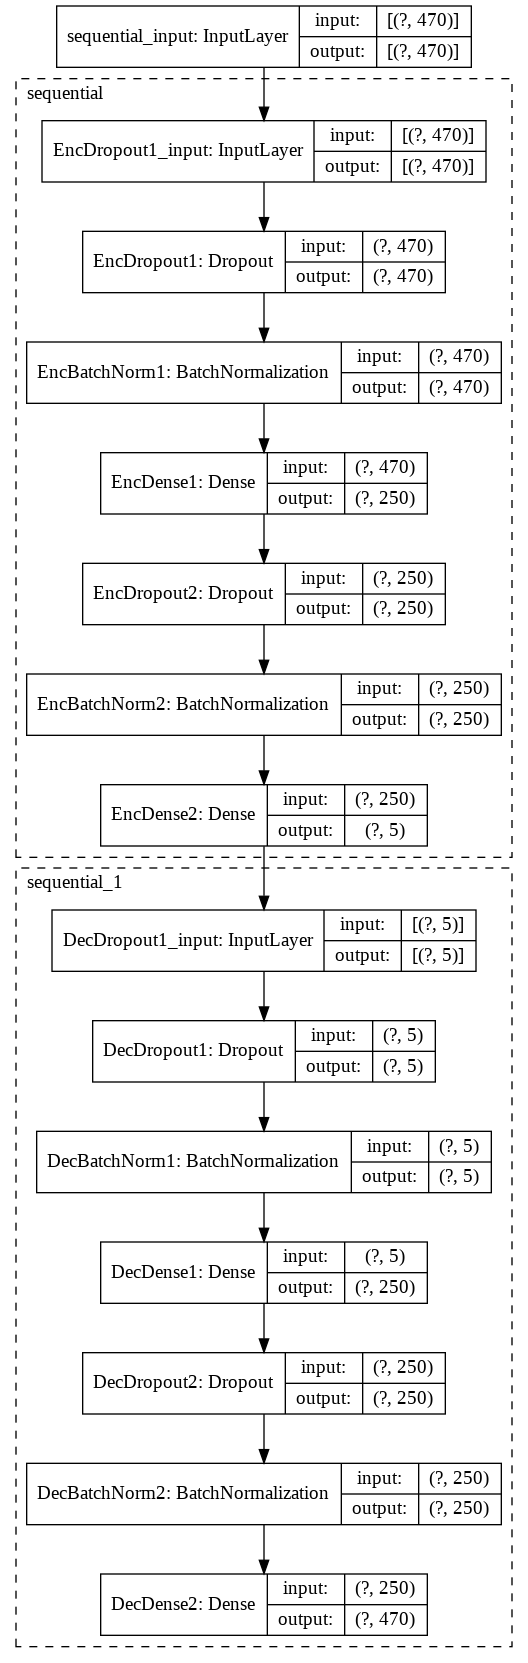

In [12]:
ae=build_model()
ae.summary()
keras.utils.plot_model(ae, show_shapes = True, show_layer_names = True, expand_nested=True)

In [13]:
gridsearch= False # activate/deactivate grid search by setting gridsearch=True resp. gridsearch=False

In [14]:
#Grid search
train =DF_adj_close_n.iloc[0:traindays,:].values.T
if gridsearch:
    keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
    param_distribs = {"n_hidden": [250,350], "learning_rate": [0.0004,0.001],"DOrate": [0.11,0.2],"lambd": [0.0001,0.001,0.01]}
    Grid_search_cv = GridSearchCV(keras_reg, param_distribs, cv=3)
    print("Doing Grid Search. This might take a while!")
    result_gs=Grid_search_cv.fit(train, train)  

In [15]:
if gridsearch:
    print("The best parameters according to the grid search are:")
    display(result_gs.best_params_)

In [16]:
# rebuild the model
ae=build_model(n_bottleneck=5, n_hidden=250, learning_rate= 0.001, DOrate= 0.2, lambd=0.0001)

In [17]:
#inlcude early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [18]:
#training
history = ae.fit(train, train, epochs=100, batch_size=30, callbacks=[early_stopping_cb], validation_data=[train, train],verbose=1)

Epoch 1/100
5/5 [==============================] - 0s 48ms/step - loss: 0.4926 - val_loss: 0.0330
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 0.3629 - val_loss: 0.0325
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 0.3138 - val_loss: 0.0320
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 0.2999 - val_loss: 0.0314
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 0.2857 - val_loss: 0.0308
Epoch 6/100
5/5 [==============================] - 0s 13ms/step - loss: 0.2719 - val_loss: 0.0302
Epoch 7/100
5/5 [==============================] - 0s 13ms/step - loss: 0.2641 - val_loss: 0.0295
Epoch 8/100
5/5 [==============================] - 0s 13ms/step - loss: 0.2482 - val_loss: 0.0289
Epoch 9/100
5/5 [==============================] - 0s 13ms/step - loss: 0.2392 - val_loss: 0.0282
Epoch 10/100
5/5 [==============================] - 0s 14ms/step - loss: 0.2247 - val_loss: 0.0276
Epoch 11/100
5/5 [=

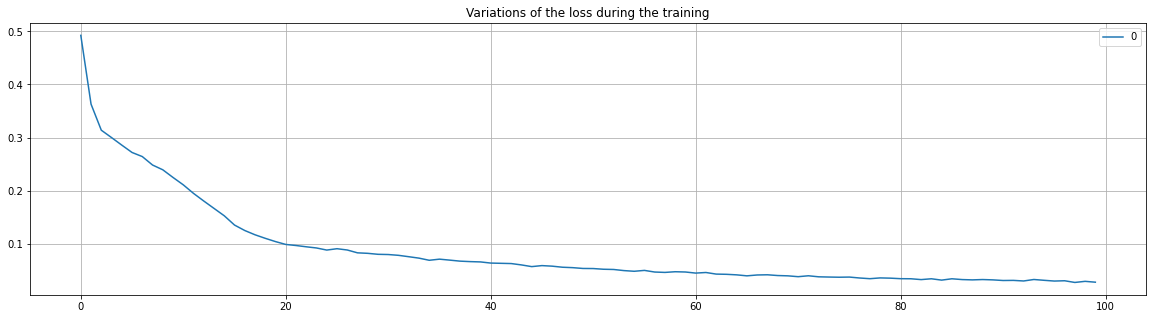

In [19]:
pd.DataFrame(history.history['loss']).plot(figsize=(20,5))
plt.grid(True)
plt.title('Variations of the loss during the training')
plt.show()

In [20]:
prediction = ae.predict(train)

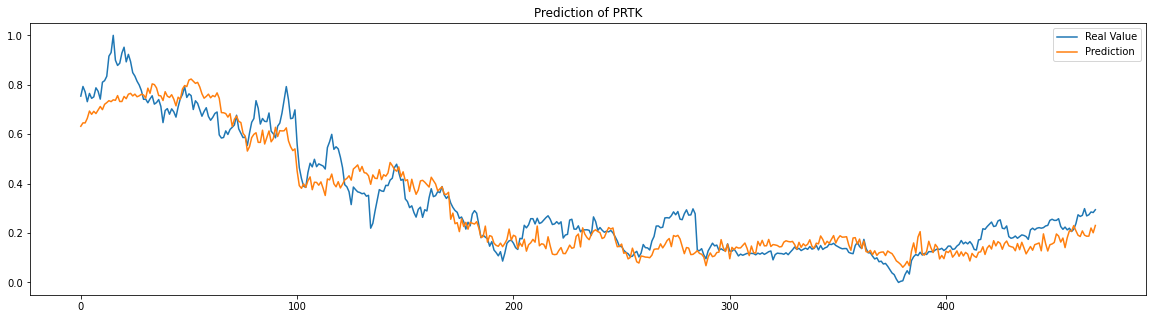

In [21]:
plot_idx = np.random.randint(low=0, high=len(train))
# Real value
plt.figure(1, figsize=(20, 5))
plt.plot(train[plot_idx], label='Real Value')
# Prediction
plt.plot(prediction[plot_idx], label='Prediction')
plt.title('Prediction of ' + str(list_tickers[plot_idx]))
plt.legend()
plt.show()

In [22]:
S = 50
N = 20

MSE_arr = ((prediction - trainset)**2).mean(axis=1)
MSE_df = pd.DataFrame(MSE_arr, index = list_tickers, columns=['MSE'])
ranking = MSE_df.sort_values('MSE',ascending = True)

most_least_c_df = return_commonals(prediction, trainset, list_tickers, S, N)
#display(most_least_c_df)
ranking
ranking.to_csv('stock_ranking.csv')

In [ ]:
#Parameters
# Training Parameters
learning_rate_calib = 0.0004 # learning rate for Adam
num_steps_calib = 100 # number of training steps (epochs)
batch_size_calib = 10 # size of the batches
lambd_calib = 0.1 # lambda for regularization
val_dropout_calib = 0.88 # keep probability for dropout
display_step_calib = 10 # stepsize for printing training epochs

# Network
num_input_calib = S # dimensions of first layer
n_hidden_calib = 5 # dimensions of bottleneck layer
num_output_calib = S # dimensions of last layer

dr_calib=1-val_dropout_calib
activation_calib="softmax"

In [ ]:
#Layers
log_rates = keras.Input(shape=[num_input_calib],name="Input")
do1= keras.layers.Dropout(rate=dr_calib)(log_rates)
bn1= keras.layers.BatchNormalization()(do1)
de1= keras.layers.Dense(n_hidden_calib, kernel_initializer='glorot_normal', bias_initializer='zeros',kernel_regularizer=regularizers.l2(lambd_calib/2))(bn1)
do2= keras.layers.Dropout(rate=dr_calib)(de1)
bn2= keras.layers.BatchNormalization()(do2)
tick_weights= keras.layers.Dense(num_output_calib, activation=activation_calib, kernel_initializer='glorot_normal', bias_initializer='zeros', kernel_regularizer=regularizers.l2(lambd_calib/2))(bn2)
rates_tot= keras.layers.dot([log_rates,tick_weights], axes=1)

rr_tot = keras.Model(log_rates, rates_tot, name="rr_tot")
rr_tot.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=learning_rate_calib))
rr_tot.summary()

In [ ]:
def logRateOfReturn(df):
    '''
    Calculates the log rates of return of the input.
    
    Args:
    df (np.Series): Series with the adjusted close prices 
    
    Return:
    log_rate_of_returns (np.Series): the logaritmic rates of return
    
    Modification: description extended
    '''   
    # Making sure dataframe is well sorted
    df_sorted = df.sort_index(ascending = True)
    
    shift = 1
    df_shifted = df_sorted.shift(shift)
    log_rate_of_returns = np.log(df_sorted / df_shifted)
    for i in range(shift):
        log_rate_of_returns = log_rate_of_returns.drop(log_rate_of_returns.index[0])

    return log_rate_of_returns

In [ ]:
def modify_benchmark(benchmark, threshold):
    '''
    changes the data of adjusted close prices of the benchmark to logaritmic rates of return.
    Additionally values that are equal or lower -threshold are set to threshold.
    
    Args:
    benchmark (np.Series): Series with the adjusted close prices of the benchmark
    threshold (float): cutoff for the logaritmic rates
    
    Return:
    rate (np.Series): the logaritmic rates of return with values set to threshold that are equal or lower -threshold
    
    Modification: description changed
    ''' 
    rate = logRateOfReturn(benchmark)
    for i in range(len(rate)):
        if rate[i] <= - threshold:
            rate[i] = threshold
    return rate

In [ ]:
def reconstruct(rates, P0):
    '''
    Calculates the value of the investment.
    
    Args:
    rates (list): logaritmic rates of return for each ticker
    PO (list): amount of invested money for each ticker of the second model at the start
    
    Return:
    prices (np.Series): value for each ticker of the second model after their courses changed by rates 
    
    Modification: description changed
    ''' 
    prices = [P0]
    for i in range(len(rates)):
        prices.append( np.exp(rates[i]) * prices[i])
    return prices

In [ ]:
threshold = 0.13
benchmark_lrets = logRateOfReturn(index_last_price)
benchmark_lrets_mod = modify_benchmark(index_last_price, threshold)

benchmark_lrets.plot(label='real log rates of return')
benchmark_lrets_mod.plot(label='modified log rates of return')

plt.title('Comparison between benchmark and modified benchmark')
plt.hlines([0,-threshold],0,len(index_pct),linestyles=["solid","dotted"])
plt.legend()
plt.savefig('Comparison between benchmark and modified benchmark in terms of ror')
plt.show()

In [ ]:
calib_returns_in = reconstruct(benchmark_lrets_mod[:traindays].values,1)
real_returns_in = reconstruct(benchmark_lrets[:traindays].values,1)



plt.plot(calib_returns_in,'r', label = "Objective")
plt.plot(real_returns_in,'y', label = "Benchmark")
plt.title('Comparison between benchmark and modified benchmark')
plt.legend()
plt.savefig('Comparison between benchmark and modified benchmark in terms of prices')
plt.show()

In [ ]:
tickers_ptfolio_2 = most_least_c_df.index
DF_most_least_c_2 = stock_last_price.loc[:,tickers_ptfolio_2]

DF_ptfolio_lrets_2 = logRateOfReturn(DF_most_least_c_2)

X_c_train_2 = DF_ptfolio_lrets_2.iloc[range(traindays),:].values
X_c_test_2 = DF_ptfolio_lrets_2.iloc[traindays:,:].values

Y_c_train_2 = benchmark_lrets_mod[:traindays].values
Y_c_test_2 = benchmark_lrets_mod[traindays:].values

In [ ]:
history1= rr_tot.fit(X_c_train_2, Y_c_train_2, epochs=num_steps_calib, batch_size=batch_size_calib, validation_data=[X_c_test_2, Y_c_test_2], verbose=1)

In [ ]:
pd.DataFrame(history1.history['loss']).plot(figsize=(20,5))
plt.grid(True)
plt.title('Variations of the loss during the training')
plt.show()

In [ ]:
ticker_weights=keras.Model(log_rates, tick_weights, name="ticker_weights")
ticker_weights.set_weights(rr_tot.get_weights())
ticker_weights.compile(loss= "mse", optimizer=keras.optimizers.Adam(learning_rate=learning_rate_calib))

In [ ]:
prediction1_2= ticker_weights.predict(X_c_train_2)
prediction2_2= ticker_weights.predict(X_c_test_2)

In [ ]:
n_in = len(prediction1_2)
weights_ptfolio_in_2 = [0]*S
for i in range(S):
    for j in prediction1_2:
        weights_ptfolio_in_2[i] += j[i]/n_in

In [ ]:
n_out = len(prediction2_2)
weights_ptfolio_out_2 = [0]*S
for i in range(S):
    for j in prediction2_2:
        weights_ptfolio_out_2[i] += j[i]/n_out

In [ ]:
#log rates of Portfoli
ptfolio_lrets_in_2 = np.dot(X_c_train_2, weights_ptfolio_in_2)
ptfolio_lrets_out_2 = np.dot(X_c_test_2, weights_ptfolio_out_2)

#Reminder: log rates of benchmark
real_benchmark_lrets_train = logRateOfReturn(index_last_price[0:traindays].reset_index(drop=True))
real_benchmark_lrets_test = logRateOfReturn(index_last_price[traindays:].reset_index(drop=True))

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(ptfolio_lrets_in_2,'b', label = "Prediction")
plt.plot([np.mean(ptfolio_lrets_in_2)]*len(ptfolio_lrets_in_2),'b-.')
plt.plot(real_benchmark_lrets_train, 'r' , label = "Objective")
plt.plot([np.mean(real_benchmark_lrets_train)]*len(real_benchmark_lrets_train),'r-.')
plt.legend()
plt.title('Comparison of the log returns of train set')
plt.show()

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(ptfolio_lrets_out_2,'b', label = "Prediction")
plt.plot([np.mean(ptfolio_lrets_out_2)]*len(ptfolio_lrets_out_2),'b-.')
plt.plot(real_benchmark_lrets_test,'r' , label = "Objective")
plt.plot([np.mean(real_benchmark_lrets_test)]*len(real_benchmark_lrets_test),'r-.')
plt.legend()
plt.title('Comparison of the log returns of test set')
plt.show()

In [ ]:
portfolio_returns_in_2 = reconstruct(ptfolio_lrets_in_2,1)
#calib_returns_in = reconstruct(Y_c_train,1)
plt.plot(portfolio_returns_in_2,'b', label = "Portfolio")
plt.plot(calib_returns_in,'r', label = "modified Benchmark")
plt.plot(real_returns_in,'y', label = "Benchmark")
plt.title('Comparison of the returns in sample TF2')
plt.legend()
plt.savefig('Comparison of the returns in sample TF2')
plt.show()

In [ ]:
portfolio_returns_out_2 = reconstruct(ptfolio_lrets_out_2,1)
calib_returns_out = reconstruct(Y_c_test_2,1)
real_returns_out = reconstruct(real_benchmark_lrets_test.values,1)

plt.plot(portfolio_returns_out_2,'b', label = "Portfolio") # Portfolio
plt.plot(calib_returns_out,'r', label = "modified Benchmark")
plt.plot(real_returns_out,'y', label = "Benchmark")
plt.title('Comparison of the returns out of sample TF2')
plt.legend()
plt.savefig('Comparison of the returns out of sample TF2')
plt.show()

2. Version

In [ ]:
# stock data
s_lp_calibrate = stock_last_price.iloc[:780, :]
s_lp_validate = stock_last_price.iloc[780:, :]

# s&p 500 data
i_lp_calibrate = pd.Series(index_last_price)[:780]
i_lp_validate = pd.Series(index_last_price)[780:]

### Select PF 

In [ ]:
# stock data
s_lp_calibrate = stock_last_price.iloc[:780, :]
s_lp_validate = stock_last_price.iloc[780:, :]
s_p_calibrate = stock_pct.iloc[0:780, :]
s_p_validate= stock_pct.iloc[780:, :]

# s&p 500 data
i_lp_calibrate = pd.Series(index_last_price)[:780]
i_lp_validate = pd.Series(index_last_price)[780:]
i_p_calibrate = pd.Series(index_pct)[:780]
i_p_validate= pd.Series(index_pct)[780:]

In [ ]:
# To beat the S&P500 index, we will amend the target data during the calibrate phase by replacing all returns smaller than -5% by exactly 5%
# Aims to create a index tracker with anti-correlation in periods of large drawdowns.

# from -5% to 5%
y_amended = i_p_calibrate
y_amended[y_amended < -0.04] = 0.04

# re-calculate the last price
y_amended[0] = 0
relative_percentage = y_amended + 1
lp_amended = i_lp_calibrate[0] * (relative_percentage.cumprod()) 

# plot comparison
#pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb original', legend=True) 
#pd.Series(lp_amended.as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb amended', legend=True)
plt.figure(figsize=(10,5))
plt.plot(s_lp_calibrate.index, pd.Series(index_last_price)[:780], label='S&P original')
plt.plot(s_lp_calibrate.index, lp_amended, label='S&P amended')
plt.legend()

In [ ]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)
index_predict_calibrate = pd.DataFrame()
total_2_norm_diff_calibrate = pd.DataFrame()
for non_communal in [10, 15, 20, 25, 30, 35, 40]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking.index[0:10], ranking.index[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.002))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.002))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = s_p_calibrate.loc[:,stock_index][1:]
    y = y_amended[1:] # amended percentage
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=400, batch_size = 10)    # fit the model
    deep_learner.save('beat_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    #relative_percentage[0] = 0
    relative_percentage = relative_percentage + 1
    
    index_predict_calibrate[s] = i_lp_calibrate[0] * (relative_percentage.cumprod())          
    total_2_norm_diff_calibrate[s] = np.linalg.norm((index_predict_calibrate[s] - lp_amended[1:])) # compare with amended last price

In [ ]:
# plot results and 2-norm differences 
plt.figure(figsize=(20,5))
plt.plot(s_lp_calibrate.index, i_lp_calibrate, label='S&P original')
plt.plot(s_lp_calibrate.index, lp_amended, label='S&P amended')

for s in [30,35,40,45]:
    plt.plot(s_lp_calibrate.index[1:], index_predict_calibrate[s], label='S&P S'+ str(s))
    plt.legend()
    #print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff_calibrate[s])    

In [ ]:
# for non_communal in [5, 10, 15, 25]:  
#     # some numerical values
#     encoding_dim = 5
#     s = 40 + non_communal
#     stock_index = np.concatenate((ranking[0:40], ranking[-non_communal:])) # portfolio index
index_predict_validate = pd.DataFrame()
for non_communal in [10, 15, 20, 25, 30, 35, 40]:  
    # some numerical values
    #encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking.index[0:10], ranking.index[-non_communal:])) # portfolio index    
    
    # load our trained models
    deep_learner = load_model('beat_s' + str(s) + '.h5')
    
    x = s_p_validate.loc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    #relative_percentage[0] = 0
    relative_percentage = relative_percentage + 1
    
    index_predict_validate[s] = i_lp_validate[0] * (relative_percentage.cumprod())          
#     total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

In [ ]:
# plot original S&P last price
plt.figure(figsize=(15,5))
plt.plot(s_lp_validate.index[:], i_lp_validate[:], label='S&P original')

# 2-norm difference is now meaningless to compare
for s in [25,30,35,45,50]:
    plt.plot(s_lp_validate.index[:], index_predict_validate[s][:], label='S&P S'+ str(s))
    plt.legend()